In [1]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 54.1 MB/s 
     |████████████████████████████████| 448 kB 63.6 MB/s 
     |████████████████████████████████| 86 kB 6.0 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-11-09 00:30:45--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff0

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import warnings
warnings.filterwarnings('ignore')

import re
import seaborn as sb

# Tools for creating ngrams and vectorizing input data
from konlpy.tag import Mecab
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Embedding, Conv1D, MaxPooling1D, BatchNormalization, Concatenate, Layer, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D, GRU, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
import os
from keras import backend as K
from gensim.models import FastText
from sklearn.neighbors import NearestNeighbors

In [3]:
class Attention(Layer):
    def __init__(self, step_dim, W_regularizer=None, b_regularizer=None, W_constraint=None, b_constraint=None, bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim  

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [131]:
#Remove morphemes from specific parts-of-speech
def pos_delete(tag, pos):
  for p in pos:
    if (p not in tag) == False:
      if 'VV+' not in tag:
        return False
      else:
        return True
    else:
      continue
  
  return True

#Parts-of-speech list
POS = ['CP', 'JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX', 'JC', 'JO', 'EP', 'EF', 'EC', 'ETN', 'ETM', 'VCP', 'VCN', 'SF', 'SY', 'XSN', 'XSV', 'XSA', 'XR']

#Vectorized using a trained FastText model
def vectorize_data(data, vocab: dict) -> list:
  keys = list(vocab.keys())
  filter_unknown = lambda word: vocab.get(word, None) is not None
  result = []
  for d in data:
    filtered = list(filter(filter_unknown,d))
    res = []
    for f in filtered:
      res.append(vocab[f].index)
    result.append(res)
  
  return result

#Build model
def build_model(embedding_matrix, maxlen):
  sequence_input = Input(shape=(maxlen,), dtype='int32')
  embedded_sequences = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],  input_length=maxlen, weights=[embedding_matrix], trainable=False)(sequence_input)
  dropout_1 = SpatialDropout1D(0.1)(embedded_sequences)
  bilstm = Bidirectional(LSTM(32, return_sequences=True))(dropout_1)
  bigru = Bidirectional(GRU(32, return_sequences=True))(bilstm)

  atten_1 = Attention(maxlen)(bilstm)
  atten_2 = Attention(maxlen)(bigru)
  avg_pool = GlobalAveragePooling1D()(bigru)
  max_pool = GlobalMaxPooling1D()(bigru)

  conc = concatenate([atten_1, atten_2, avg_pool, max_pool])
  dense = Dense(16, activation='relu')(conc)
  dropout_2 = Dropout(0.1)(dense)
  output = Dense(1, activation='sigmoid')(dropout_2)

  model = Model(inputs=sequence_input, outputs=output)
  model.summary()

  return model

#Make synonym dictionary
def make_synonyms():
  synonyms_number = 5
  word_number = 20000
  embed_mat = ft_model.wv.vectors
  nn = NearestNeighbors(n_neighbors=synonyms_number+1).fit(embed_mat)
  neighbours_mat = nn.kneighbors(embed_mat[1:word_number])[1]
  nei_mat = []

  for i in range(len(neighbours_mat)):
    tmp = [ft_model.wv.index2word[s] for s in neighbours_mat[i]]
    nei_mat.append(tmp)

  synonyms = {nei[0]: nei[1:] for nei in nei_mat}

  return synonyms

#Modify train sentence with synonym dictionary
def modify_sentence(X_pos, synonyms, p=0.5):
    sentence = [ft_model.wv.index2word[x] for x in np.trim_zeros(X_pos)]
    for i in range(len(sentence)):
        if np.random.random() > p:
            try:
                syns = synonyms[sentence[i]]
                sentence[i] = np.random.choice(syns)
            except KeyError:
                pass
    return sentence

#Final function. Generate new hate sentence with synonym dictionary (with modify_sentence function)
def text_generator(X_pad, y_data, synonyms):
  X_pos = X_pad[y_data==1]
  n_texts = 15000
  indexes = np.random.randint(0, X_pos.shape[0], n_texts)
  
  X_gen = np.array([modify_sentence(x, synonyms) for x in X_pos[indexes]])
  y_gen = np.ones(n_texts)

  split_X_gen = []
  for i in range(len(X_gen)):
    split_X_gen.append([gen for gen in X_gen[i]])

  return split_X_gen, y_gen

#Text tokenize function (To use Predictor function)
def text_tokenize(text):
  mecab = Mecab()
  train_tokenized = []

  ps = mecab.pos(text)
  tagged = []
  for p in ps:
    if pos_delete(p[1], POS):
      tagged.append(p[0])
  temp_X = [word for word in tagged]
  train_tokenized.append(temp_X)

  return train_tokenized

#Visulaize confusion matrix
def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

#Convert to probability corresponding to each label
def predict_proba(pred):
  proba = []
  for i in range(len(pred)):
    proba.append([float(1-pred[i]), pred[i][0]])
  
  return proba

#Class prediction based on the transformed probability
def class_predict(proba):
  return np.argmax(proba, axis=1)

#Determine max_len function
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('Proportion of samples with length %s or less among all samples: %s'%(max_len, (count / len(nested_list))*100))


In [134]:
#Train data load +  Tagging + Spliting + FastText Model load
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/train_data.csv', encoding='cp949')
train_data['comments'] = train_data['comments'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]','')

mecab = Mecab()
train_tokenized = []

for comment in train_data['comments']:
  ps = mecab.pos(comment)
  tagged = []
  for p in ps:
    if pos_delete(p[1], POS):
      tagged.append(p[0])
    temp_X = [word for word in tagged]
  train_tokenized.append(temp_X)

ft_model = FastText.load('/content/drive/MyDrive/Colab Notebooks/model/fasttext_310k_1109.model')

In [135]:
#Make Synonyms dictionary
synonyms = make_synonyms()

In [136]:
#Define X_data and y_data
X_data = train_tokenized
y_data = train_data['hate'].values

In [137]:
#View Ratio Length
below_threshold_len(35, X_data)

Proportion of samples with length 35 or less among all samples: 98.89632936507937


In [138]:
#Comment Vectorize with FastText Model (train_data)
max_len = 35
padded_X = pad_sequences(
    sequences=vectorize_data(X_data, vocab=ft_model.wv.vocab),
    maxlen=max_len,
    padding='post'
)

In [139]:
#Generate Sentence with synonym dictionary
X_pos = padded_X[y_data==1]
split_X_gen, y_gen = text_generator(padded_X, y_data, synonyms)
mix_X = X_data + split_X_gen
mix_y = np.hstack((y_data, y_gen))

#Comment Vectorize with FastText Model (Generate_data)
max_len = 35
X_pad = pad_sequences(
    sequences=vectorize_data(mix_X, vocab=ft_model.wv.vocab),
    maxlen=max_len,
    padding='post'
)

#Final Input data: X_pad(x_data), mix_y(y_data)

In [140]:
#Split train data, validation data and test data
X_train, X_vt, y_train, y_vt = train_test_split(X_pad, mix_y, test_size=0.2, shuffle=True, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_vt, y_vt, test_size=0.3, shuffle=True, random_state=42)

In [141]:
X_train

array([[ 1733, 75036, 59561, ...,     0,     0,     0],
       [10760,    65,     0, ...,     0,     0,     0],
       [   23, 13520,   549, ...,     0,     0,     0],
       ...,
       [66859,   320, 65501, ...,     0,     0,     0],
       [  224,    15,  9936, ...,     0,     0,     0],
       [17286,    24,  4899, ...,     0,     0,     0]], dtype=int32)

In [142]:
#Define matrics(TP, FP, TN, FN, Accuracy, Precision, Recall, AUC)
METRICS = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 35, 100)      9236500     input_5[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_4 (SpatialDro (None, 35, 100)      0           embedding_4[0][0]                
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) (None, 35, 64)       34048       spatial_dropout1d_4[0][0]        
____________________________________________________________________________________________

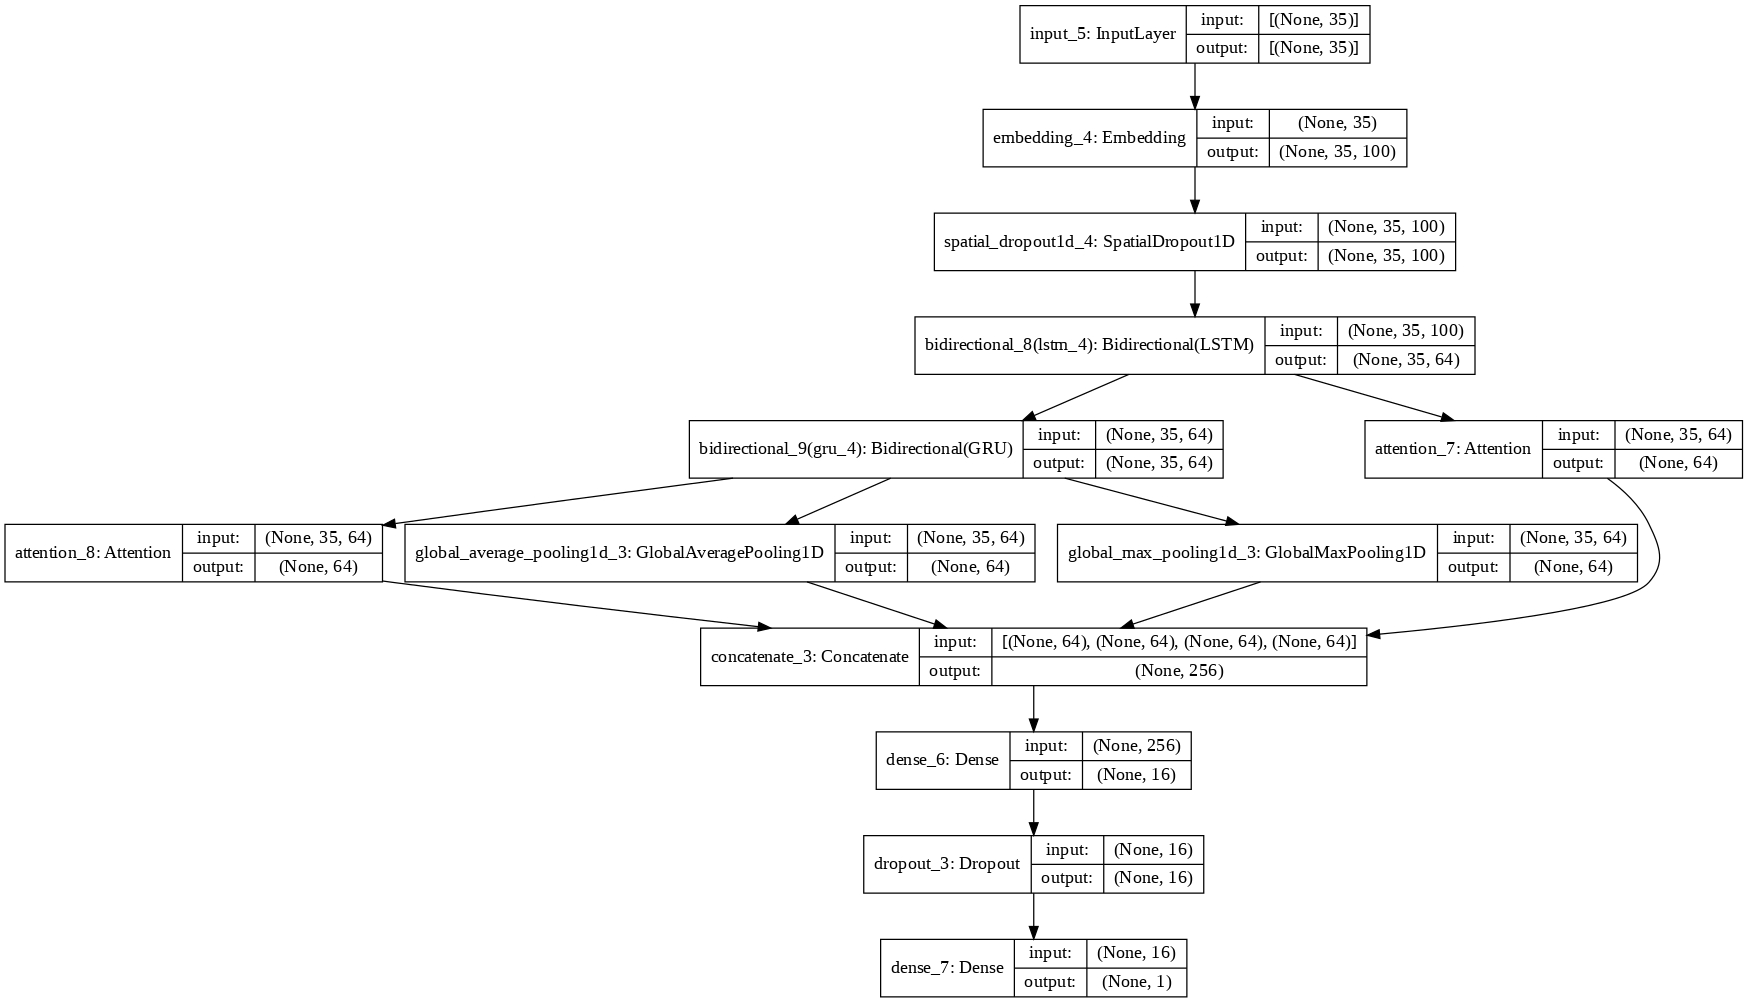

In [143]:
#Model define and train, visualize model tree
model = build_model(embedding_matrix=ft_model.wv.vectors, maxlen=max_len)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)
keras.utils.plot_model(model, show_shapes=True, dpi=90)

In [144]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=100, epochs=10)

print('Model train complete.')

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_proba = predict_proba(train_pred)
test_pred_proba = predict_proba(test_pred)

train_preds = class_predict(train_pred_proba)
test_preds = class_predict(test_pred_proba)

print('Data predict complete.')


Epoch 1/10
314/314 [==============================] - 40s 103ms/step - loss: 0.4680 - accuracy: 0.7722 - precision: 0.7822 - recall: 0.7581 - auc: 0.8584 - val_loss: 0.3727 - val_accuracy: 0.8425 - val_precision: 0.8151 - val_recall: 0.8899 - val_auc: 0.9207
Epoch 2/10
314/314 [==============================] - 30s 97ms/step - loss: 0.3790 - accuracy: 0.8343 - precision: 0.8275 - recall: 0.8472 - auc: 0.9108 - val_loss: 0.3290 - val_accuracy: 0.8599 - val_precision: 0.8602 - val_recall: 0.8624 - val_auc: 0.9346
Epoch 3/10
314/314 [==============================] - 30s 96ms/step - loss: 0.3337 - accuracy: 0.8554 - precision: 0.8489 - recall: 0.8666 - auc: 0.9314 - val_loss: 0.2953 - val_accuracy: 0.8693 - val_precision: 0.9033 - val_recall: 0.8299 - val_auc: 0.9511
Epoch 4/10
314/314 [==============================] - 31s 98ms/step - loss: 0.2934 - accuracy: 0.8740 - precision: 0.8735 - recall: 0.8763 - auc: 0.9473 - val_loss: 0.2859 - val_accuracy: 0.8815 - val_precision: 0.8421 - val_

              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91      1207
         1.0       0.87      0.95      0.91      1145

    accuracy                           0.91      2352
   macro avg       0.91      0.91      0.91      2352
weighted avg       0.91      0.91      0.91      2352



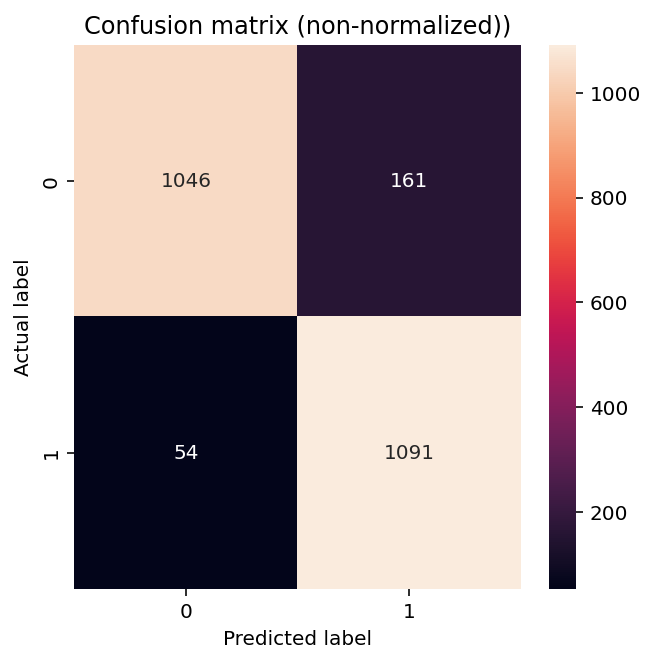

In [145]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
  
report = classification_report(y_test, test_preds)
print(report)
  
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
    
plot_cm(y_test, test_preds)

In [162]:
def predictor(text, vocab=ft_model.wv.vocab, maxlen=max_len):
  pattern = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣]')
  text = re.sub(pattern, ' ', text)
  tokenized = text_tokenize(text)
  tokenized_padded = pad_sequences(sequences=vectorize_data(tokenized, vocab=vocab), maxlen=maxlen, padding='post')

  print("Regexed Text:         ", text)
  print("Tokenized Text:       ", tokenized)
  ratio = round(model.predict(tokenized_padded)[0][0] * 100, 2)
  print(f'{ratio}% 확률로 욕설 문장입니다.')
  print('----------------------------------------')
  print('욕설 부분 분석\n')
  badword_list = []
  for idx, token in enumerate(tokenized[0]):
    pad_token = pad_sequences(sequences=vectorize_data([[token]], vocab=ft_model.wv.vocab), maxlen=35, padding='post')
    token_ratio = round(model.predict(pad_token)[0][0] * 100, 2)
    print(token + '\t: ' + str(token_ratio) +'% 확률로 욕설 부분')
    if token_ratio > 50:
      badword_list.append(token)
  
  return badword_list

In [163]:
text='이 새끼는 뭐하는 새끼'
badword = predictor(text)
masked_text = masker(text, badword)

print('-'*20)
print("Original Text: ", text)
print("Masked Text:   ", masked_text)

Regexed Text:          이 새끼는 뭐하는 새끼
Tokenized Text:        [['이', '새끼', '뭐', '하', '새끼']]
99.52% 확률로 욕설 문장입니다.
----------------------------------------
욕설 부분 분석

이	: 16.72% 확률로 욕설 부분
새끼	: 99.36% 확률로 욕설 부분
뭐	: 6.38% 확률로 욕설 부분
하	: 8.16% 확률로 욕설 부분
새끼	: 99.36% 확률로 욕설 부분
--------------------
Original Text:  이 새끼는 뭐하는 새끼
Masked Text:    이 **는 뭐하는 **


In [164]:
def masker(text, badword):
  masked_text = text
  for bad in badword:
    masked_text = masked_text.replace(bad, '*' * len(bad), 1)
  
  return masked_text

In [166]:
text='아 씨발 진짜 개 좆같네'
badword = predictor(text)
masked_text = masker(text, badword)

print('-'*20)
print("Original Text: ", text)
print("Masked Text:   ", masked_text)

Regexed Text:          아 씨발 진짜 개 좆같네
Tokenized Text:        [['아', '씨발', '진짜', '개', '좆같']]
99.4% 확률로 욕설 문장입니다.
----------------------------------------
욕설 부분 분석

아	: 6.85% 확률로 욕설 부분
씨발	: 99.49% 확률로 욕설 부분
진짜	: 10.57% 확률로 욕설 부분
개	: 77.28% 확률로 욕설 부분
좆같	: 84.81% 확률로 욕설 부분
--------------------
Original Text:  아 씨발 진짜 개 좆같네
Masked Text:    아 ** 진짜 * **네


In [167]:
text='안녕하세요!! 이번에 들어온 사람입니다.'
badword = predictor(text)
masked_text = masker(text, badword)

print('-'*20)
print("Original Text: ", text)
print("Masked Text:   ", masked_text)

Regexed Text:          안녕하세요   이번에 들어온 사람입니다 
Tokenized Text:        [['안녕', '이번', '들어온', '사람']]
0.69% 확률로 욕설 문장입니다.
----------------------------------------
욕설 부분 분석

안녕	: 2.78% 확률로 욕설 부분
이번	: 2.56% 확률로 욕설 부분
들어온	: 5.03% 확률로 욕설 부분
사람	: 2.92% 확률로 욕설 부분
--------------------
Original Text:  안녕하세요!! 이번에 들어온 사람입니다.
Masked Text:    안녕하세요!! 이번에 들어온 사람입니다.
